In [1]:
%matplotlib inline
import sys, os
sys.path.append("../")
import numpy as np
import scipy as sp
import numpy.linalg as nla
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from timeit import timeit
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss
from drot.solver import drot, drot_
from drot.proximal import *
import csv
%load_ext autoreload
%autoreload 2

# Optimal transport

In [59]:
def save(C, nrows, ncols, filename):
    assert C.flags['F_CONTIGUOUS']   
    output_file = open(filename, 'wb')
    C.tofile(output_file)
    output_file.close()

def one_dimensional_gaussian_ot(n):
    t = np.arange(0, n)/n
    Gaussian = lambda t0, sigma: np.exp(-(t-t0)**2 / (2*sigma**2))
    normalize = lambda p: p / np.sum(p)
    sigma = 0.1;
    p = Gaussian(.75, sigma)
    q = Gaussian(.15, sigma)
    vmin = .02;
    p = normalize(p + np.max(p) * vmin)
    q = normalize(q + np.max(q) * vmin)
    [Y,X] = np.meshgrid(t,t)
    C = np.array((X-Y)**2, order='F')
    return n, C, p, q

def two_dimensional_gaussian_ot(m, n):
    mu_s = np.array([0, 0.5])
    cov_s = np.array([[1, 0.15], [0.15, 1]])
    mu_t = np.array([4, 10])
    cov_t = np.array([[1, -.8], [-.8, 1]])
    xs = ot.datasets.make_2D_samples_gauss(m, mu_s, cov_s)
    xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)
    p, q = np.ones((m,)) / m, np.ones((n,)) / n  
    C = np.array(ot.dist(xs, xt), order='F')
    C /= C.max()
    # C32 = np.array(C, order='F').astype(np.float32)
    # save(C32, m, n, "../gpu/data/cmatrix")
    return m, n, C, p, q


In [60]:
def multi_experiment(m, n, max_iters, accuracies, skregs, alpha=1.0, ntests=20, verbskip=1):
    num_accuracies = accuracies.shape[0]
    num_algs = skregs.shape[0] + 1
    # outs = np.zeros([num_algs, int(max_iters/verbskip), num_accuracies, ntests])
    outs = np.zeros([num_algs, 1, num_accuracies, ntests])
    
    for test_idx in range(ntests):
        print("\n *** Experiment", test_idx+1, "of", ntests, "***")
        m, n, C, p, q = two_dimensional_gaussian_ot(m, n)
        x0 = np.array(np.outer(p, q), order = 'F')
        step = alpha / (m+n)
        
        C_ = C.copy()
        G0 = ot.emd(p, q, C_, numItermax=1_000_000)
        optval = np.sum(G0 * C_)

        drout = drot_(x0, C, p, q, max_iters=max_iters, step=step, compute_r_primal=True, 
                        compute_r_dual=False, adapt_stepsize=False, eps_abs=1e-4, eps_rel=0.0)
        
        skout = []                        
        for reg in skregs:
            skout.append(ot.sinkhorn(p, q, C_, reg, numItermax=1000, stopThr=7e-5))
        
        outs[0, 0, :, test_idx] = abs(np.sum(drout['sol']*C) - optval) / optval
        for sk_idx in range(skregs.shape[0]):
           outs[sk_idx+1, 0, :, test_idx] = abs(np.sum(skout[sk_idx]*C_) - optval) / optval

    file_name = 'Dims_' + str(m) + '_test_' + str(ntests)
    np.save('output/'+file_name + '.npy', outs)
    return file_name

def profile(dir, accuracies, labels, colors):     
    outs = np.load(dir)
    (num_algs, num_objs_computed, num_accuracies, ntests) = outs.shape
    performance_ratio = np.zeros((num_algs, num_accuracies))
    
    for alg_idx in range(num_algs):
        for acc_idx in range(num_accuracies):
            performance_ratio[alg_idx, acc_idx] = np.sum((outs[alg_idx, 0, acc_idx, :] <= accuracies[acc_idx])) / ntests

    fig = plt.figure()        
    for alg_idx in range(num_algs):
        plt.plot(accuracies, performance_ratio[alg_idx, :], color=colors[alg_idx], label=labels[alg_idx], linewidth=2.5)
  
    ylabel = r'Performance ratio'
    plt.xlabel(r'Final accuracy')
    plt.ylabel(ylabel)
    plt.xscale('log')
    plt.legend()
        
    return fig

In [64]:
m, n = 500, 500
max_iters = 1000
accuracies = np.logspace(-4.5, -1, num=15)
skregs = np.array([1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1])

file_name = multi_experiment(m, n, max_iters, accuracies, skregs, alpha=2, ntests=50)


 *** Experiment 1 of 50 ***
Drot done at iteration  999

 *** Experiment 2 of 50 ***


/Users/vienmai/miniconda3/envs/common/lib/python3.8/site-packages/ot/bregman.py:363: RuntimeWarning: divide by zero encountered in true_divide
  v = np.divide(b, KtransposeU)


Drot done at iteration  974

 *** Experiment 3 of 50 ***
Drot done at iteration  958

 *** Experiment 4 of 50 ***
Drot done at iteration  988

 *** Experiment 5 of 50 ***
Drot done at iteration  999

 *** Experiment 6 of 50 ***
Drot done at iteration  999

 *** Experiment 7 of 50 ***
Drot done at iteration  862

 *** Experiment 8 of 50 ***
Drot done at iteration  960

 *** Experiment 9 of 50 ***
Drot done at iteration  911

 *** Experiment 10 of 50 ***
Drot done at iteration  999

 *** Experiment 11 of 50 ***
Drot done at iteration  862

 *** Experiment 12 of 50 ***
Drot done at iteration  999

 *** Experiment 13 of 50 ***
Drot done at iteration  999

 *** Experiment 14 of 50 ***
Drot done at iteration  999

 *** Experiment 15 of 50 ***
Drot done at iteration  999

 *** Experiment 16 of 50 ***
Drot done at iteration  999

 *** Experiment 17 of 50 ***
Drot done at iteration  999

 *** Experiment 18 of 50 ***
Drot done at iteration  999

 *** Experiment 19 of 50 ***
Drot done at iteratio

/Users/vienmai/miniconda3/envs/common/lib/python3.8/site-packages/ot/bregman.py:363: RuntimeWarning: overflow encountered in true_divide
  v = np.divide(b, KtransposeU)


Drot done at iteration  999

 *** Experiment 30 of 50 ***
Drot done at iteration  990

 *** Experiment 31 of 50 ***
Drot done at iteration  999

 *** Experiment 32 of 50 ***
Drot done at iteration  766

 *** Experiment 33 of 50 ***
Drot done at iteration  888

 *** Experiment 34 of 50 ***
Drot done at iteration  999

 *** Experiment 35 of 50 ***
Drot done at iteration  999

 *** Experiment 36 of 50 ***
Drot done at iteration  999

 *** Experiment 37 of 50 ***
Drot done at iteration  982

 *** Experiment 38 of 50 ***
Drot done at iteration  998

 *** Experiment 39 of 50 ***
Drot done at iteration  999

 *** Experiment 40 of 50 ***
Drot done at iteration  984

 *** Experiment 41 of 50 ***
Drot done at iteration  952

 *** Experiment 42 of 50 ***
Drot done at iteration  914

 *** Experiment 43 of 50 ***
Drot done at iteration  999

 *** Experiment 44 of 50 ***
Drot done at iteration  999

 *** Experiment 45 of 50 ***
Drot done at iteration  999

 *** Experiment 46 of 50 ***
Drot done at i

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


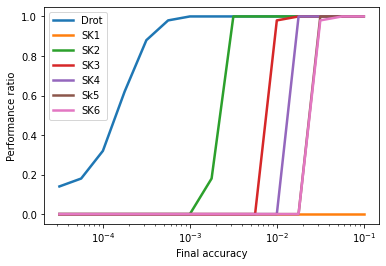

In [65]:
labels = ['Drot', 'SK1', 'SK2', 'SK3', 'SK4', 'Sk5', 'SK6']
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
dir = "output/" + file_name  + '.npy'
fig = profile(dir, accuracies, labels, colors)

# fig.savefig('Figures/'+ file_name + '.eps', format='eps')

Drot done at iteration  383


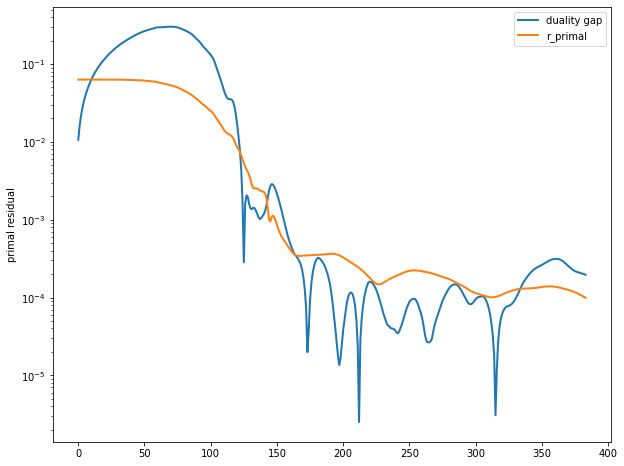

In [49]:
m, n, C, p, q = two_dimensional_gaussian_ot(500, 500)
x0 = np.array(np.outer(p, q), order = 'F')
max_iters = 1000
step = .751 / (m+n)

assert C.flags['F_CONTIGUOUS']   
assert x0.flags['F_CONTIGUOUS']   

proxf = lambda x, stz: trace_nonnegative_prox(x, C, stz)
proxg = lambda x, stz: generalized_doubly_stochastic_matrices_projection(x, p, q)
proxg_ = lambda x, y, stz: primal_dual_trace_nonnegative_prox(x, C, y, stz)
proxh = lambda x, xnew, y, stz: primal_dual_linear_prox(x, xnew, y, p, q, stz)

drout_  = drot_(x0, C, p, q, max_iters=max_iters, step=step, compute_r_primal=True, 
              compute_r_dual=True, adapt_stepsize=False, max_step=20*step, min_step=step/100,
              eps_abs=1e-4, eps_rel=0, verbose=False, print_every=100)
xopt_ = drout_["sol"]

plt.figure(1, figsize=(10,8))

plt.plot(range(drout_["num_iters"]), [ f for f in drout_['dual']], label='duality gap', linewidth=2)
plt.plot(range(drout_["num_iters"]), [r for r in drout_['primal']], label='r_primal', linewidth=2)
plt.ylabel("primal residual") 
plt.yscale('log')
plt.legend()

Text(0, 0.5, 'Primal Residual')

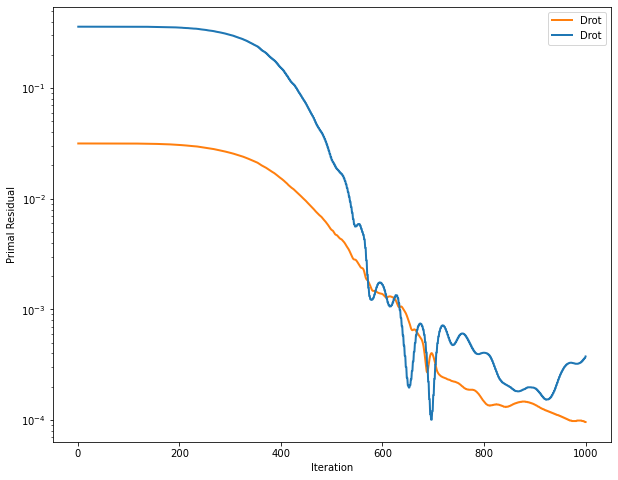

In [17]:
filenames = [ '../gpu/output/drot.csv' ];
labels = ['Drot']
colors = ['C0', 'C1']
markers = ['', '']
fig1 = plt.figure(figsize=(10, 8))

optval = 0.35937378885602755

for i in range(len(filenames)):
    k = []; t = []; r = []; f = [];
    with open(filenames[i]) as csvfile:
        csvReader = csv.reader(csvfile, delimiter=",")
        next(csvReader)  # skip the header
        for row in csvReader:
            k.append(int(row[0]))
            t.append(float(row[1]))
            r.append(float(row[2]))
            f.append(float(row[3]))

        plt.plot(k, [res for res in r], color=colors[i+1], marker=markers[i], label=labels[i], linewidth=2)
        plt.plot(k, [abs(fval - optval) for fval in f], color=colors[i], marker=markers[i], label=labels[i], linewidth=2)


plt.yscale('log')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Primal Residual")

In [42]:
C_ = C.copy()
G0 = ot.emd(p, q, C_, numItermax=1_000_000)
Gsk = ot.sinkhorn(p, q, C_, 1e-3, verbose=True, numItermax=1000, stopThr=7e-5)
Gsb = ot.bregman.sinkhorn_stabilized(p, q, C_, 1e-4, verbose=False, numItermax=200, stopThr=7e-5)

It.  |Err         
-------------------
    0|4.032383e-01|
   10|3.414337e-02|
   20|9.586986e-03|
   30|3.458837e-03|
   40|1.297794e-03|
   50|4.895757e-04|
   60|1.848501e-04|
   70|6.980573e-05|


In [43]:
fdr, femd, fsk, fsb = np.sum(xopt_*C), np.sum(G0*C_), np.sum(Gsk*C_), np.sum(Gsb*C_)
fdr, femd, fsk, fsb

(0.42402607490981453,
 0.42395343750251396,
 0.4247564632222826,
 1.6158566264730292e-06)

In [44]:
(fdr-femd) / femd, (fsk-femd) / femd, (fsb-femd) / femd

(0.00017133345522204414, 0.001894136593158027, -0.999996188598833)

In [ ]:
np.sum(xopt_ > 0), np.sum(G0 > 0), np.sum(Gsk > 0)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].imshow(xopt_, interpolation='nearest')
axs[0, 0].set_title('OT matrix DR')

axs[0, 1].imshow(G0, interpolation='nearest')
axs[0, 1].set_title('OT matrix G0')

axs[1, 1].imshow(Gs, interpolation='nearest')
axs[1, 1].set_title('OT matrix Sinkhorn')

In [ ]:
pl.figure(3, figsize=(6, 4))
ot.plot.plot1D_mat(p, q, xopt.T, 'OT matrix DR')
# pl.title("---")

pl.figure(6, figsize=(6, 4))
ot.plot.plot1D_mat(p, q, G0, 'OT matrix LP')

pl.figure(9, figsize=(6, 4))
ot.plot.plot1D_mat(p, q, Gs, 'OT matrix Sinkhorn')
pl.show()